# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]

### Member 1: Aniket Mishra

### Member 2: Anindita Sarkar

<!-- ### Member 3: It's A Me, Mario -->

### Member 3: Mario Trabert


In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub


# add additonal imports here
class FashionDataset(Dataset):
    def __init__(
        self, csv_file, img_dir, column_class="articleTypeId", transform=None
    ):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(
            self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg"
        )  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

## Importing more libraries cuz y not


In [2]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torch.nn as nn
from typing import Tuple, List, Dict, Optional, Type, Any
from torch import optim
from torch.optim.lr_scheduler import StepLR, CyclicLR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
import time
from matplotlib import cm

import torch.multiprocessing

torch.multiprocessing.set_start_method("spawn", force=True)

from dataset import FashionDataset
from datetime import datetime


Download data with kagglehub


In [3]:
# dataset_path = "/Users/aniket/TU_Eindhoven/2_Study/Q4_2AMM15_Deep_Learning/4_Code/2AMM15_Deep_Learning/Assighment_1/datasets/"

In [4]:
dataset_path = kagglehub.dataset_download(
    "paramaggarwal/fashion-product-images-small"
)
img_dir = os.path.join(dataset_path, "images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.


In [5]:
local_data_path = "/Users/aniket/TU_Eindhoven/2_Study/Q4_2AMM15_Deep_Learning/4_Code/2AMM15_Deep_Learning/Assighment_1/dataset"

In [6]:
dataset = FashionDataset(
    f"{local_data_path}/train.csv",
    img_dir,
)

In [7]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


In [8]:
dataset.df

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0
...,...,...,...,...,...
35929,13398,Shirts,Topwear,1,0
35930,53734,Casual Shoes,Shoes,2,1
35931,11033,Tops,Topwear,6,0
35932,22334,Tshirts,Topwear,0,0


In [9]:
dataset.img_dir

'/Users/aniket/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1/images'

In [10]:
dataset.df["imageId"].min()

1163

In [11]:
len(set(dataset.targets))

39

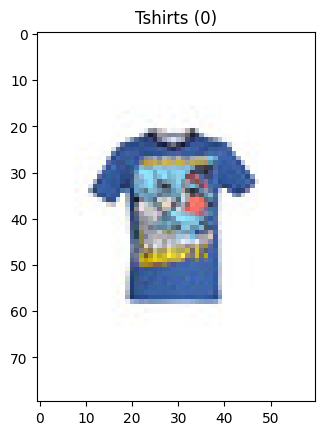

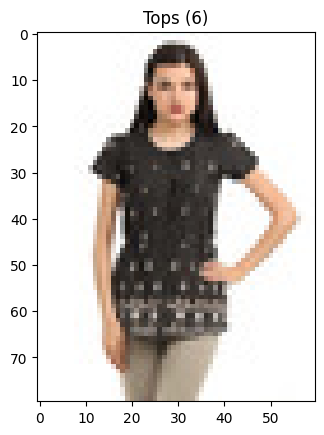

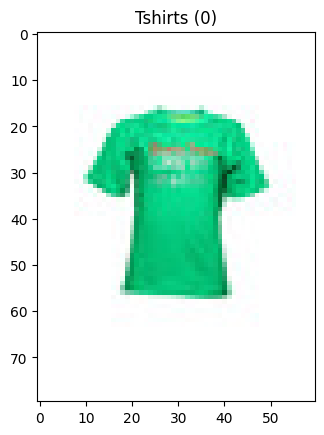

In [12]:
np.random.seed(42)
# np.random.seed(69)
random_indices = np.random.choice(len(dataset), 3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"] + f" ({label.item()})")
    plt.imshow(img)
    plt.show()

In [13]:
# Setting up default values, I forget to change them everywhere
batch_size = 512
learning_rate = 0.0001
all_birbs = sorted(list(set(dataset.targets)))
num_classes = len(set(dataset.targets))

resize_pixels_x = 128
resize_pixels_y = 128
crop_size = 128

In [14]:
transform = transforms.Compose(
    [
        transforms.Resize((resize_pixels_x, resize_pixels_y)),
        transforms.RandomResizedCrop(
            crop_size
        ),  # Crop yoinks stuff completely, gotta skip ig?
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(
            (-15, 15), interpolation=InterpolationMode.NEAREST
        ),  # Rotate +-15 degrees cuz not text, we can
        transforms.ColorJitter(brightness=0.1, contrast=0.15, saturation=0.2),
        # Data Augmentation - end
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((resize_pixels_x, resize_pixels_y)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ]
)

## Loading different datasets


In [15]:
# transform = transforms.Compose([...])  # your image transformations
train_dataset = FashionDataset(
    f"{local_data_path}/train.csv",
    img_dir,
    transform=transform,
)
main_test_dataset = FashionDataset(
    f"{local_data_path}/main_test.csv",
    img_dir,
    transform=test_transform,
)
new_test_dataset = FashionDataset(
    f"{local_data_path}/new_test.csv",
    img_dir,
    transform=test_transform,
)
main_support_dataset = FashionDataset(
    f"{local_data_path}/main_support.csv",
    img_dir,
    transform=test_transform,
)
new_support_dataset = FashionDataset(
    f"{local_data_path}/new_support.csv",
    img_dir,
    transform=test_transform,
)
merged_test_dataset = FashionDataset(
    f"{local_data_path}/merged_test.csv",
    img_dir,
    transform=test_transform,
)  # merged corresponds to main+new
merged_support_dataset = FashionDataset(
    f"{local_data_path}/merged_support.csv",
    img_dir,
    transform=test_transform,
)

# datasets with categories
main_test_dataset_cat = FashionDataset(
    f"{local_data_path}/main_test.csv",
    img_dir,
    column_class="categoryId",
    transform=test_transform,
)
main_support_dataset_cat = FashionDataset(
    f"{local_data_path}/main_support.csv",
    img_dir,
    column_class="categoryId",
    transform=test_transform,
)


label_id_to_label_name = {
    i: train_dataset.df[train_dataset.df["articleTypeId"] == i][
        "articleTypeName"
    ].iloc[0]
    for i in range(39)
}
label_id_to_label_name.update(
    {
        i: new_test_dataset.df[new_test_dataset.df["articleTypeId"] == i][
            "articleTypeName"
        ].iloc[0]
        for i in range(39, 39 + 30)
    }
)

## Task 1


In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()

        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetCNN2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNetCNN2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2)

        self.layer1 = ResidualBlock(16, 32, downsample=False)
        self.layer2 = ResidualBlock(32, 64, downsample=True)
        self.layer3 = ResidualBlock(64, 128, downsample=True)
        # self.layer4 = ResidualBlock(128, 128, downsample=True)
        self.layer4 = ResidualBlock(128, 256, downsample=True)

        self.dropout = nn.Dropout(0.1)

        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, 128, 128)
            x = self.conv1(dummy_input)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.pool(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            # x = self.layer4(x)
            x = self.layer4(x)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def get_embeddings(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        return x


print("ResNet CNN2 defined")

ResNet CNN2 defined


In [17]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(device)
print(torch.version.xpu)

mps
None


In [19]:
model = ResNetCNN2(in_channels=3, num_classes=num_classes)
model = model.to(device)
model

ResNetCNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): Ba

In [20]:
# Learning Rate Scheduler
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1) # Example: reduce LR every 7 epochs


In [21]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, balanced_accuracy_score # 
import time
import matplotlib.pyplot as plt # For plotting loss and accuracy


In [22]:
# num_epochs = 25
# num_epochs = 75
num_epochs = 1

print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning Rate Scheduler
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


Using device: mps
Number of classes: 39
Batch size: 512
Learning rate: 0.0001


In [23]:
import os
cpu_count = os.cpu_count()
cpu_count

12

In [24]:
cpu_count

12

# Train or not train model:


In [25]:
train_model = True

In [26]:
train_loader = DataLoader(
	dataset=train_dataset,
	batch_size=batch_size,
	shuffle=True,
	num_workers=cpu_count-2,
	pin_memory=True if device in ["cuda", "mps"] else False
)

test_loader = DataLoader(
	dataset=main_test_dataset, 
	batch_size=batch_size,
	shuffle=False,
	num_workers=cpu_count-1,
	pin_memory=True if device == ["cuda", "mps"] else False
)

print(f"Train loader: {len(train_loader)} batches, {len(train_loader.dataset)} samples")
print(f"Test loader: {len(test_loader)} batches, {len(test_loader.dataset)} samples")

Train loader: 71 batches, 35934 samples
Test loader: 4 batches, 1997 samples



Starting training...
0
Epoch [1/1], Step [17/71], Batch Loss: 2.8462
Epoch [1/1], Step [34/71], Batch Loss: 2.6031
Epoch [1/1], Step [51/71], Batch Loss: 2.3207
Epoch [1/1], Step [68/71], Batch Loss: 2.1380
Epoch [1/1] completed in 135.75s:
  Training Loss: 2.6246, Training Accuracy: 27.37%
  Test Loss: 1.8360, Test Accuracy: 46.62%, Test Balanced Accuracy: 23.86%

Finished Training.


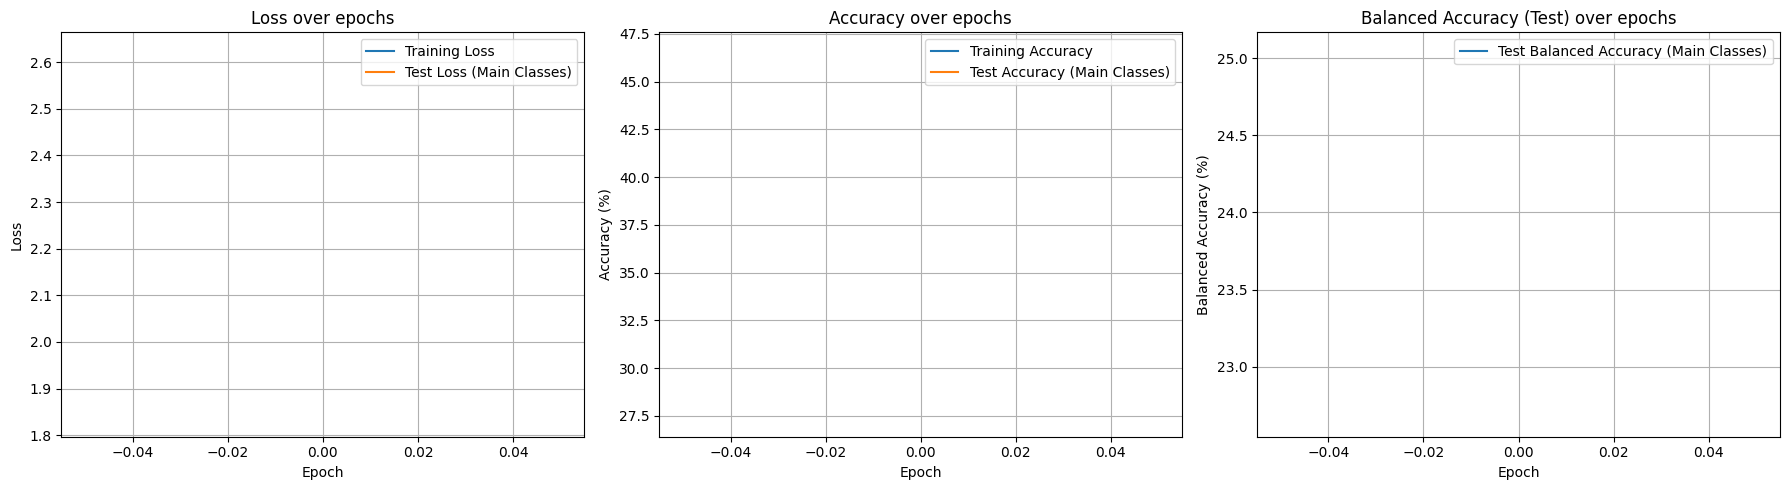

<Figure size 640x480 with 0 Axes>

In [27]:

if 'train_dataset' not in locals() or 'main_test_dataset' not in locals():
	print("Please ensure train_dataset and main_test_dataset are defined.")
elif train_model == False:
    print("Not training the model.")
else:
	train_losses = []
	test_losses = []
	train_accuracies = []
	test_accuracies = []
	test_balanced_accuracies = []

	print("\nStarting training...")
	for epoch in range(num_epochs):
		print(epoch)
		model.train()
		running_loss = 0.0
		correct_train = 0
		total_train = 0
		epoch_start_time = time.time()

		for i, (images, labels) in enumerate(train_loader):
			images = images.to(device)
			labels = labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			running_loss += loss.item() * images.size(0) # loss.item() is avg loss for batch

			_, predicted = torch.max(outputs.data, 1)
			total_train += labels.size(0)
			correct_train += (predicted == labels).sum().item()

			if (i + 1) % (len(train_loader) // 4) == 0 and i != 0 : # Print progress a few times per epoch
					print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
						f"Batch Loss: {loss.item():.4f}")

		epoch_loss = running_loss / total_train
		epoch_acc = 100 * correct_train / total_train
		train_losses.append(epoch_loss)
		train_accuracies.append(epoch_acc)

		if 'scheduler' in locals():
			scheduler.step()

		model.eval()
		correct_test = 0
		total_test = 0
		running_test_loss = 0.0
		all_test_preds = []
		all_test_labels = []

		with torch.no_grad(): 
			for images, labels in test_loader:
				images = images.to(device)
				labels = labels.to(device)

				outputs = model(images)
				loss = criterion(outputs, labels)
				running_test_loss += loss.item() * images.size(0)

				_, predicted = torch.max(outputs.data, 1)
				total_test += labels.size(0)
				correct_test += (predicted == labels).sum().item()
				all_test_preds.extend(predicted.cpu().numpy())
				all_test_labels.extend(labels.cpu().numpy())

		epoch_test_loss = running_test_loss / total_test
		epoch_test_acc = 100 * correct_test / total_test
		epoch_test_balanced_acc = balanced_accuracy_score(all_test_labels, all_test_preds) * 100

		test_losses.append(epoch_test_loss)
		test_accuracies.append(epoch_test_acc)
		test_balanced_accuracies.append(epoch_test_balanced_acc)

		epoch_end_time = time.time()
		epoch_duration = epoch_end_time - epoch_start_time

		print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s:")
		print(f"  Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")
		print(f"  Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.2f}%, Test Balanced Accuracy: {epoch_test_balanced_acc:.2f}%")
		if epoch_test_acc >= 75 and epoch_test_balanced_acc >= 75:
			print(f"  Performance target reached on main classes test set at epoch {epoch+1}!")


	print("\nFinished Training.")

	plt.figure(figsize=(18, 5))

	plt.subplot(1, 3, 1)
	plt.plot(train_losses, label="Training Loss")
	plt.plot(test_losses, label="Test Loss (Main Classes)")
	plt.title("Loss over epochs")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.grid(True)

	plt.subplot(1, 3, 2)
	plt.plot(train_accuracies, label="Training Accuracy")
	plt.plot(test_accuracies, label="Test Accuracy (Main Classes)")
	plt.title("Accuracy over epochs")
	plt.xlabel("Epoch")
	plt.ylabel("Accuracy (%)")
	plt.legend()
	plt.grid(True)

	plt.subplot(1, 3, 3)
	plt.plot(test_balanced_accuracies, label="Test Balanced Accuracy (Main Classes)")
	plt.title("Balanced Accuracy (Test) over epochs")
	plt.xlabel("Epoch")
	plt.ylabel("Balanced Accuracy (%)")
	plt.legend()
	plt.grid(True)

	plt.tight_layout()
	plt.show()

	os.makedirs("outputs/images", exist_ok=True)
	timestamp = datetime.now().strftime("%Y%m%d_%H%M")

	plot_save_path = f"outputs/images/training_curves_{timestamp}.png"
	plt.savefig(plot_save_path)


Saving dem models ez


In [28]:
if train_model == True:
	timestamp = datetime.now().strftime("%Y%m%d_%H%M")

	save_path = f"outputs/models/resnetcnn2_task1_1epoch_{timestamp}.pth"
	torch.save(model.state_dict(), save_path)
	print(f"Model saved to {save_path}")

	# save_path = f"outputs/models/resnetcnn2_task1.pth"
	# torch.save(model.state_dict(), save_path)
	# print(f"Model saved to {save_path}")
else:
    print("DId not train model, not saving.")

Model saved to outputs/models/resnetcnn2_task1_1epoch_20250526_0827.pth


## Task 2


In [29]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

In [30]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)


In [31]:
model = ResNetCNN2(in_channels=3, num_classes=39)
model.load_state_dict(torch.load("outputs/models/resnetcnn2_task1.pth", map_location=device))
model = model.to(device)
model.eval()
print("Model loaded and ready for Task 2")


Model loaded and ready for Task 2


In [32]:
from sklearn.metrics import balanced_accuracy_score
import torch
import numpy as np
import tqdm


def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            emb = model.get_embeddings(images).cpu()
            embeddings.append(emb)
            labels.append(lbls)
    return torch.cat(embeddings), torch.cat(labels)


def classify_with_support(query_embeddings, support_embeddings, support_labels, k=1):
    distances = torch.cdist(query_embeddings, support_embeddings)  # shape: [N_query, N_support]
    topk_indices = distances.topk(k, largest=False).indices       # shape: [N_query, k]
    topk_labels = support_labels[topk_indices]                    # shape: [N_query, k]
    pred_labels = torch.mode(topk_labels, dim=1).values
    return pred_labels


def evaluate_with_support(model, support_dataset, test_dataset, device, batch_size=512, k=1):
    support_loader = DataLoader(support_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    support_embeddings, support_labels = extract_embeddings(model, support_loader, device)
    test_embeddings, test_labels = extract_embeddings(model, test_loader, device)

    pred_labels = classify_with_support(test_embeddings, support_embeddings, support_labels, k)

    acc = (pred_labels == test_labels).float().mean().item() * 100
    bal_acc = balanced_accuracy_score(test_labels.numpy(), pred_labels.numpy()) * 100
    return acc, bal_acc


In [33]:
print("\nEvaluating Task 2 Scenarios...\n")

scenarios = {
    "Scenario 1 (Train support → Main test)": (train_dataset, main_test_dataset),
    "Scenario 2 (Main support → Main test)": (main_support_dataset, main_test_dataset),
    "Scenario 3 (New support → New test)": (new_support_dataset, new_test_dataset),
    "Scenario 4 (Merged support → Merged test)": (merged_support_dataset, merged_test_dataset),
}

for name, (support_set, test_set) in scenarios.items():
	acc, bal_acc = evaluate_with_support(model, support_set, test_set, device)
	print(f"{name}:")
	print(f"  Accuracy:         {acc:.2f}%")
	print(f"  Balanced Accuracy:{bal_acc:.2f}%\n")

	scenario_id = name.split("(")[0].strip().replace(" ", "_").lower()
	timestamp = datetime.now().strftime("%Y%m%d_%H%M")
	model_save_path = f"outputs/models/resnetcnn2_task2_{scenario_id}_{timestamp}.pth"

	torch.save(model.state_dict(), model_save_path)
	print(f"Saved model to {model_save_path}\n")



Evaluating Task 2 Scenarios...

Scenario 1 (Train support → Main test):
  Accuracy:         82.07%
  Balanced Accuracy:78.20%

Saved model to outputs/models/resnetcnn2_task2_scenario_1_20250526_0828.pth

Scenario 2 (Main support → Main test):
  Accuracy:         80.92%
  Balanced Accuracy:75.26%

Saved model to outputs/models/resnetcnn2_task2_scenario_2_20250526_0828.pth

Scenario 3 (New support → New test):
  Accuracy:         80.42%
  Balanced Accuracy:80.06%

Saved model to outputs/models/resnetcnn2_task2_scenario_3_20250526_0828.pth

Scenario 4 (Merged support → Merged test):
  Accuracy:         74.02%
  Balanced Accuracy:68.90%

Saved model to outputs/models/resnetcnn2_task2_scenario_4_20250526_0828.pth



## Task 3


In [34]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

## Task 4


In [35]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset

In [36]:
article_to_category = {
    i: train_dataset.df[train_dataset.df["articleTypeId"] == i]["categoryId"].iloc[0]
    for i in range(39)
}
article_to_category.update({
    i: new_test_dataset.df[new_test_dataset.df["articleTypeId"] == i]["categoryId"].iloc[0]
    for i in range(39, 39 + 30)
})


In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


In [38]:
model = ResNetCNN2(in_channels=3, num_classes=39)
model.load_state_dict(torch.load(
    "outputs/models/resnetcnn2_task1.pth", map_location=device))
model = model.to(device)
model.eval()

ResNetCNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): Ba

In [39]:
features = []
labels = []
img_indices = []

with torch.no_grad():
    for batch_idx, (images, lbls) in enumerate(train_loader):
        mask = (lbls < 10)
        if not mask.any():
            continue
        images = images[mask].to(device)
        lbls = lbls[mask]
        if len(lbls) == 0:
            continue
        emb = model.get_embeddings(images)
        features.append(emb.cpu().numpy())
        labels.append(lbls.cpu().numpy())
        # Track which dataset indices these images came from:
        base_idx = batch_idx * train_loader.batch_size
        batch_indices = np.arange(base_idx, base_idx + len(mask))[mask.cpu().numpy()]
        img_indices.extend(batch_indices)

features = np.concatenate(features)
labels = np.concatenate(labels)
img_indices = np.array(img_indices)


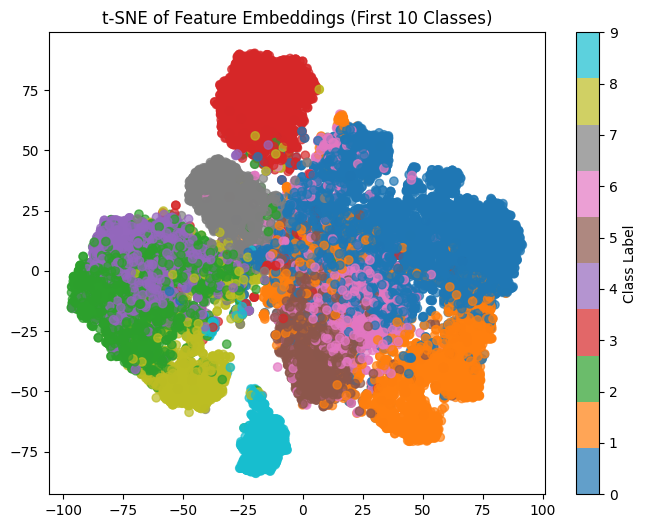

In [40]:
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(features)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Class Label')
plt.title('t-SNE of Feature Embeddings (First 10 Classes)')
plt.show()

In [41]:
features_test = []
labels_test = []
img_indices_test = []

with torch.no_grad():
    curr_idx = 0
    for images, lbls in test_loader:
        mask = (lbls < 10)
        if not mask.any():
            curr_idx += len(lbls)
            continue
        images = images[mask].to(device)
        lbls = lbls[mask]
        if len(lbls) == 0:
            curr_idx += len(lbls)
            continue
        emb = model.get_embeddings(images)
        features_test.append(emb.cpu().numpy())
        labels_test.append(lbls.cpu().numpy())
        # Track dataset indices for this batch
        img_indices_test.extend(range(curr_idx, curr_idx + len(lbls)))
        curr_idx += len(lbls)

features_test = np.concatenate(features_test)
labels_test = np.concatenate(labels_test)
img_indices_test = np.array(img_indices_test)
print("Test feature shape:", features_test.shape)
print("Test img_indices_test shape:", img_indices_test.shape)


Test feature shape: (1253, 256)
Test img_indices_test shape: (1253,)


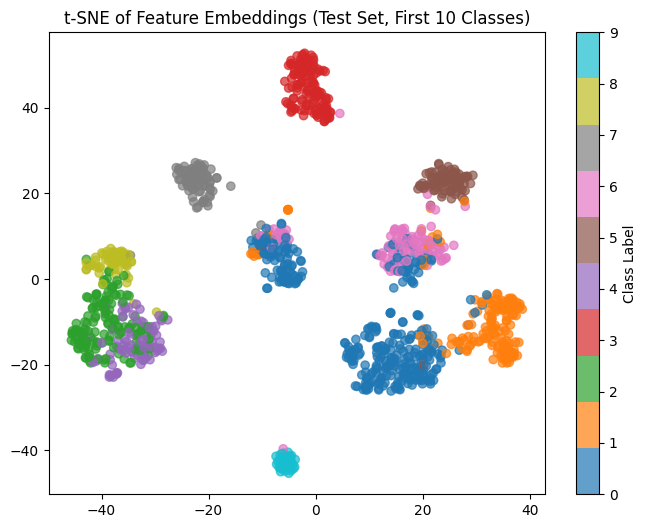

In [42]:
X_embedded_test = TSNE(n_components=2, random_state=42).fit_transform(features_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded_test[:, 0], X_embedded_test[:, 1], c=labels_test, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Class Label')
plt.title('t-SNE of Feature Embeddings (Test Set, First 10 Classes)')
plt.show()

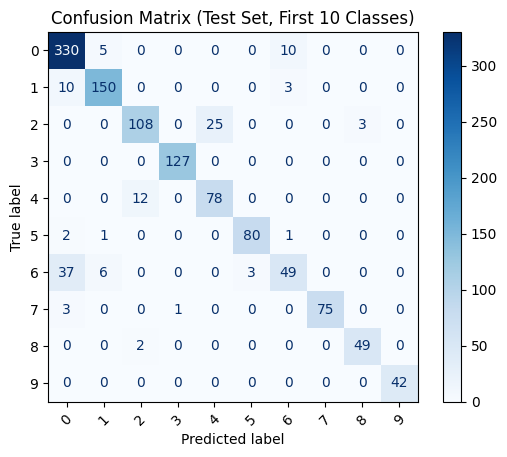

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, lbls in test_loader:
        mask = (lbls < 10)
        if not mask.any():
            continue
        images = images[mask].to(device)
        lbls = lbls[mask]
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()
        all_preds.append(preds)
        all_labels.append(lbls)

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Test Set, First 10 Classes)")
plt.show()


In [44]:
dataset.df

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0
...,...,...,...,...,...
35929,13398,Shirts,Topwear,1,0
35930,53734,Casual Shoes,Shoes,2,1
35931,11033,Tops,Topwear,6,0
35932,22334,Tshirts,Topwear,0,0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9843137].


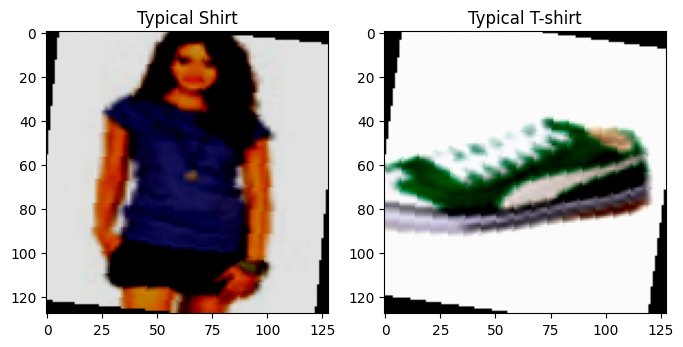

In [45]:
def compute_centroid(features, labels, class_idx):
    feats = features[labels == class_idx]
    return feats.mean(axis=0)

shirt_idx = 0
tshirt_idx = 1

centroid_shirt = compute_centroid(features, labels, shirt_idx)
centroid_tshirt = compute_centroid(features, labels, tshirt_idx)

def closest_image_idx(features, centroid):
    dists = np.linalg.norm(features - centroid, axis=1)
    return np.argmin(dists)

idx_shirt = closest_image_idx(features, centroid_shirt)
idx_tshirt = closest_image_idx(features, centroid_tshirt)

# Show images using tracked indices!
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(train_loader.dataset[img_indices[idx_shirt]][0].permute(1,2,0))  # <-- Use img_indices
axs[0].set_title("Typical Shirt")
axs[1].imshow(train_loader.dataset[img_indices[idx_tshirt]][0].permute(1,2,0))  # <-- Use img_indices
axs[1].set_title("Typical T-shirt")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].


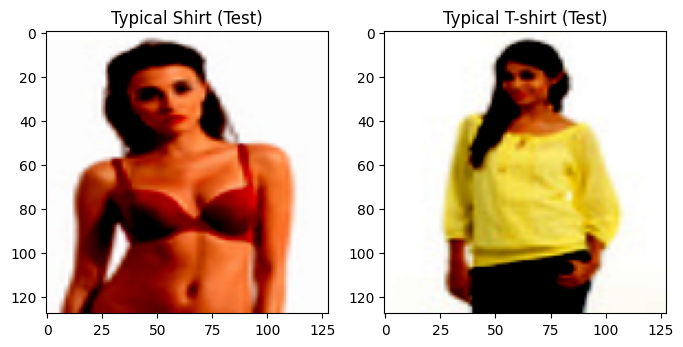

In [46]:
centroid_shirt_test = compute_centroid(features_test, labels_test, shirt_idx)
centroid_tshirt_test = compute_centroid(features_test, labels_test, tshirt_idx)

idx_shirt_test = closest_image_idx(features_test, centroid_shirt_test)
idx_tshirt_test = closest_image_idx(features_test, centroid_tshirt_test)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(test_loader.dataset[img_indices_test[idx_shirt_test]][0].permute(1,2,0))
axs[0].set_title("Typical Shirt (Test)")
axs[1].imshow(test_loader.dataset[img_indices_test[idx_tshirt_test]][0].permute(1,2,0))
axs[1].set_title("Typical T-shirt (Test)")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..0.8039216].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9843137].


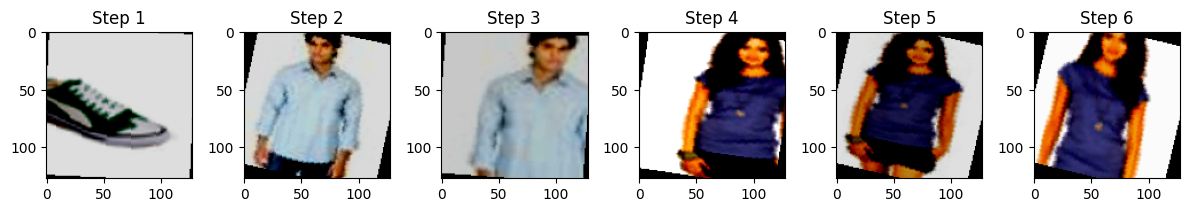

In [47]:
num_steps = 6
transitions = [
    centroid_tshirt + (centroid_shirt - centroid_tshirt) * i/(num_steps-1)
    for i in range(num_steps)
]
closest_idxs = [closest_image_idx(features, pt) for pt in transitions]

fig, axs = plt.subplots(1, num_steps, figsize=(num_steps*2, 3))
for i, idx in enumerate(closest_idxs):
    axs[i].imshow(train_loader.dataset[img_indices[idx]][0].permute(1, 2, 0))  # Use img_indices!
    axs[i].set_title(f"Step {i+1}")
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


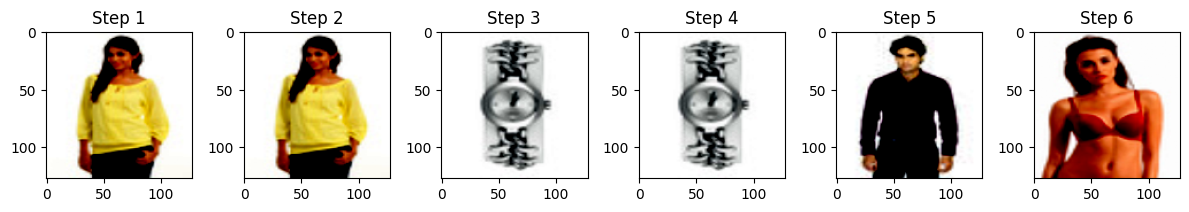

In [48]:
transitions_test = [
    centroid_tshirt_test + (centroid_shirt_test - centroid_tshirt_test) * i/(num_steps-1)
    for i in range(num_steps)
]
closest_idxs_test = [closest_image_idx(features_test, pt) for pt in transitions_test]

fig, axs = plt.subplots(1, num_steps, figsize=(num_steps*2, 3))
for i, idx in enumerate(closest_idxs_test):
    axs[i].imshow(test_loader.dataset[img_indices_test[idx]][0].permute(1, 2, 0))
    axs[i].set_title(f"Step {i+1}")
plt.tight_layout()
plt.show()


# 4


In [49]:
unique_type_ids = np.unique(
    np.concatenate([
        train_dataset.df["articleTypeId"].unique(),
        test_loader.dataset.df["articleTypeId"].unique()
    ])
)

article_to_category = {
    i: train_dataset.df[train_dataset.df["articleTypeId"] == i]["categoryId"].iloc[0]
    if i in train_dataset.df["articleTypeId"].unique()
    else test_loader.dataset.df[test_loader.dataset.df["articleTypeId"] == i]["categoryId"].iloc[0]
    for i in unique_type_ids
}

category_preds = np.array([article_to_category[int(p)] for p in all_preds])
category_labels = np.array([article_to_category[int(y)] for y in all_labels])


Category-level accuracy: 0.9785


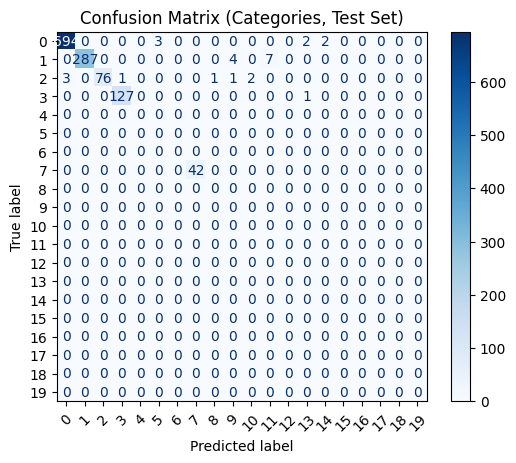

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cat_acc = accuracy_score(category_labels, category_preds)
print(f"Category-level accuracy: {cat_acc:.4f}")

num_cats = len(set(article_to_category.values()))
cm_cat = confusion_matrix(category_labels, category_preds, labels=range(num_cats))

disp_cat = ConfusionMatrixDisplay(confusion_matrix=cm_cat, display_labels=range(num_cats))
disp_cat.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Categories, Test Set)")
plt.show()
